## <span style="color:green"> Notebook - Mantle Water Content and Rheology from MT</span>
<span style="color:purple">Sinan Ozaydin, School of Geosciences, The University of Sydney, NSW 2006, Australia <br/> </span>
<span style="color:purple">sinan.ozaydin@protonmail.com | sinan.ozaydin@sydney.edu.au </span>

In [1]:
import os
from pathlib import Path
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from netCDF4 import Dataset

import pide
from pide.mt.mt_model_read import read_ModEM_rho
from pide.utils.utils import read_csv, associate_coordinates
from pide.utils.gis_tools import lat_lon_to_utm, get_utm_zone_number
from pide.inversion import conductivity_solver_single_param

import time

notebook_path = Path().resolve()

/home/sinan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In this notebook, we will convert the MT models of Western United States into water content maps at 96 and 150 km. This will require a simple inversion process with the given environment. We will use the same cells in Notebook 7 to read the models and assign the relevant indexes.

First of all, let's read the MT model by using the ***read_ModEM_rho*** function and determine the model center in UTM coordinates to georeference the model using the functions from ***pide.utils.gis_tools***. We will be using the depths according to 96 and 155 kilometer slices to calculate our water content maps.

In [2]:
wus_rho_path = os.path.join(notebook_path,'..','example_data','WUS_MT_Model','WUS.MT.Bedrosian2021.resistivity.rho')

#model centers for georeferencing
mc_lat = 40.75
mc_lon = -113.25

utm_no = get_utm_zone_number(mc_lon)
mc_x, mc_y = lat_lon_to_utm(mc_lat,mc_lon)

#reading the MT model file
rho, mesh_x, mesh_y, mesh_z = read_ModEM_rho(rho_file_path=wus_rho_path)

#converting x and y to utm coordinates
x = mesh_x
y = mesh_y

#Getting the vertical indexes of 
idx_96 = (np.abs((mesh_z/1e3) - 96.0)).argmin()
idx_155 = (np.abs((mesh_z/1e3) - 155.0)).argmin()

#Getting the resistivities at 50 and 100 km
rho_96 = rho[idx_96].flatten()
rho_155 = rho[idx_155].flatten()

cond_96 = 1.0/rho_96
cond_155 = 1.0/rho_155

/home/sinan/src/SEL/pide/utils/gis_tools.py:42: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  utm_x, utm_y = transform(wgs84, utm, longitude, latitude)


Now, let's read the temperature model with the help of utils.read_csv function. and then georefence them into the UTM coordinates.

In [3]:
#Reading the temperature model
T_path = os.path.join(notebook_path,'..','example_data','WUS_MT_Model','WinterCGTemp_Cropped_WUS.lis')
data_T = read_csv(filename=T_path, delim = ' ')
data_T = np.array(data_T[1:], dtype = float) #Skipping header  with 1:

data_T_depth = data_T[:,3]
data_T_temp = data_T[:,4] + 273.15 #converting from C to K
data_T_lat = data_T[:,2]
data_T_lon = data_T[:,1] - 360.0 #Converting it to negative before Greenwich.

#Getting all indices of latitude and longitude by using a single depth.
data_T_lat = data_T_lat[np.where(data_T_depth==-49.0)[0]]
data_T_lon = data_T_lon[np.where(data_T_depth==-49.0)[0]]

x_T, y_T = lat_lon_to_utm(latitude = data_T_lat, longitude = data_T_lon, zone_number = utm_no)

x_T = x_T - mc_x
y_T = y_T - mc_y


T_96 = data_T_temp[np.where(data_T_depth==-97.0)[0]]
T_155 = data_T_temp[np.where(data_T_depth==-155.0)[0]]

#We want to make these calculations at 50 and 100 km. So only loading the T at those temperatures.

/home/sinan/src/SEL/pide/utils/gis_tools.py:42: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  utm_x, utm_y = transform(wgs84, utm, longitude, latitude)


We also want to interpolate the temperature data between the points so we will have a more accurate distribution of temperature at each MT x,y location.

In [4]:
#2D interpolation of Temperature field to make 

x_new = np.arange(np.amin(x_T),np.amax(x_T),30e3) #every 5_000 m
y_new = np.arange(np.amin(y_T),np.amax(y_T),30e3) #every 5_000 m

coords_mesh = np.meshgrid(x_new, y_new)

points_interp = np.column_stack((x_T, y_T))


T_96_interp = griddata(points_interp, T_96, (coords_mesh[0], coords_mesh[1]), method = 'cubic')
T_155_interp = griddata(points_interp, T_155, (coords_mesh[0], coords_mesh[1]), method = 'cubic')


T_96_interp = T_96_interp.flatten()
T_155_interp = T_155_interp.flatten()
coords_x = coords_mesh[0].flatten()
coords_y = coords_mesh[1].flatten()

#Applying mask for nan values at T due to interpolation out of bounds
mask = np.isnan(T_96_interp)
T_96_i = T_96_interp[~mask]
T_155_i = T_155_interp[~mask]
coords_x = coords_x[~mask]
coords_y = coords_y[~mask]

Now, we want to find the corresponding index numbers of temperature grid for the each MT grid locality. We can do that by the pide function form ***utils.utils.associate_coordinates*** function.

In [5]:
##associateding coordinates for with

idx_ = associate_coordinates(sample_x = coords_x, sample_y = coords_y, target_x=x, target_y=y, num_cpu = 5)

Now that we have our temperature and MT model, we can set up the compositional environment to calculate the water content maps. To do this we first have to set up the compositional environment and how the water will behave in here.

In [6]:
p_obj = pide.pide()
#T-P and composition
p_obj.set_temperature(T_96_i[idx_])
p_obj.set_pressure(96.0 / 33.0 * np.ones(len(T_96_i[idx_]))) #pressure roughly calculated with Depth[km]/33km - GPa
p_obj.set_composition_solid_mineral(ol = 0.6,opx = 0.25,cpx = 0.1, garnet= 0.05)
p_obj.revalue_arrays()

#water thermodynamics
p_obj.set_mantle_water_partitions(opx = 3, cpx = 6, garnet = 0)
p_obj.set_parameter('ti_ol', 0.1)
p_obj.set_mantle_water_solubility(opx = 3, ol = 4, cpx = 1, garnet = 0)
max_water = p_obj.calculate_bulk_mantle_water_solubility()

p_obj.set_mineral_conductivity_choice(ol = 4, opx = 0, garnet = 0, cpx = 6)
p_obj.set_solid_phs_mix_method(1) #HS lower bound

water_96, residual_list = conductivity_solver_single_param(object = p_obj, cond_list = cond_96,
param_name = 'bulk_water', upper_limit_list = max_water,
		lower_limit_list= np.zeros(len(max_water)), search_start = 20, acceptence_threshold = 0.5,
        num_cpu = 5)
water_96 = np.array(water_96)

Inversion process has started..
Inversion process has ended..


In [7]:
#Calculating the 155 km slice.
p_obj.reset()

p_obj.set_temperature(T_155_i[idx_])
p_obj.set_pressure(155.0 / 33.0) #pressure roughly calculated with Depth[km]/33km - GPa
p_obj.set_composition_solid_mineral(ol = 0.6,opx = 0.25,cpx = 0.1, garnet= 0.05)
p_obj.set_mineral_conductivity_choice(ol = 4, opx = 0, garnet = 0, cpx = 6)
p_obj.revalue_arrays()

#water thermodynamics
p_obj.set_mantle_water_partitions(opx = 3, cpx = 6, garnet = 0)
p_obj.set_parameter('ti_ol', 0.1)
p_obj.set_mantle_water_solubility(opx = 3, ol = 4, cpx = 1, garnet = 0)
max_water = p_obj.calculate_bulk_mantle_water_solubility()

p_obj.set_mineral_conductivity_choice(ol = 4, opx = 0, garnet = 0, cpx = 6)
p_obj.set_solid_phs_mix_method(1) #HS lower bound

water_155, residual_list = conductivity_solver_single_param(object = p_obj, cond_list = cond_155,
param_name = 'bulk_water', upper_limit_list = max_water,
		lower_limit_list= np.zeros(len(max_water)), search_start = 20, acceptence_threshold = 0.5,
        num_cpu = 5)

Inversion process has started..
Inversion process has ended..


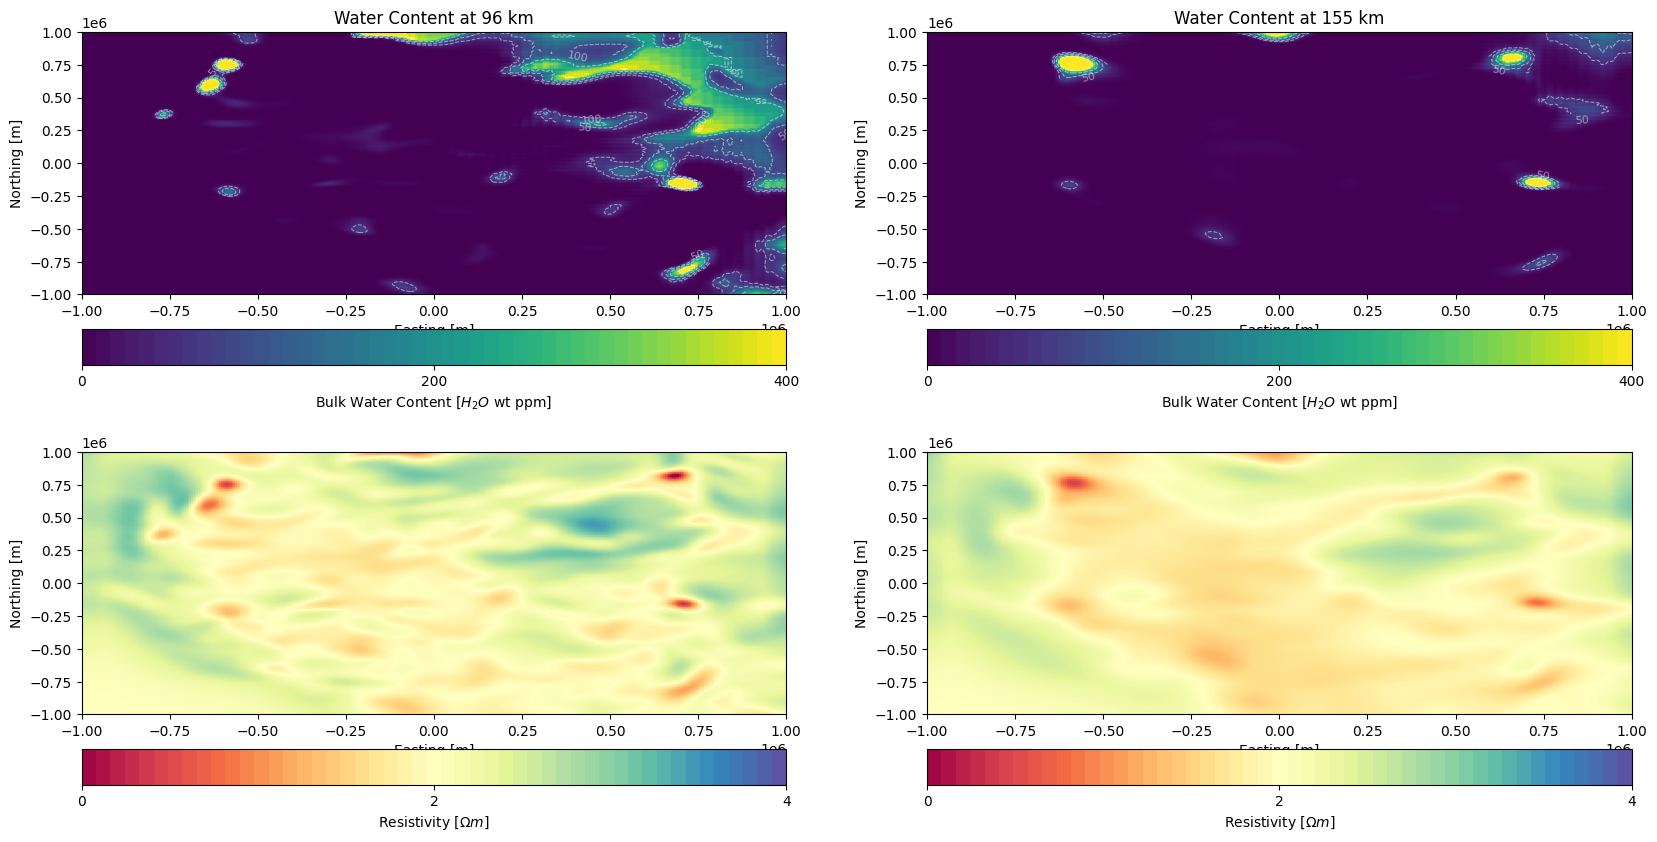

In [8]:
xi = np.arange(np.amin(x), np.amax(x),5e3)
yi = np.arange(np.amin(y), np.amax(y),5e3)

x_i,  y_i = np.meshgrid(xi,yi)

points_interp = np.column_stack((x, y))

water_96_ = griddata(points_interp, water_96, (x_i, y_i), method = 'cubic')
water_155_ = griddata(points_interp, water_155, (x_i, y_i), method = 'cubic')
res_96 = griddata(points_interp, np.log10(rho_96), (x_i, y_i), method = 'cubic')
res_155 = griddata(points_interp, np.log10(rho_155), (x_i, y_i), method = 'cubic')

fig = plt.figure(figsize = (20,10))
ax1 = plt.subplot(221)
cax1 = ax1.pcolormesh(xi,yi, water_96_, cmap = 'viridis')
cax1.set_clim(0,400)
cbar_ax = fig.colorbar(cax1, boundaries= np.linspace(0,400), orientation="horizontal", pad=0.1,
			 ticks = [0,200,400], ax = ax1, label = r'Bulk Water Content [$H_2O$ wt ppm]')

cont = ax1.contour(xi, yi, water_96_, levels = [50, 100, 200, 400], alpha = 0.5,colors = 'white',linewidths = 0.75, linestyles = '--')
ax1.clabel(cont, cont.levels, inline = True, fontsize = 8, colors = 'white')
ax1.set_xlim(-1e6,1e6)
ax1.set_ylim(-1e6,1e6)
ax1.set_xlabel('Easting [m]')
ax1.set_ylabel('Northing [m]')
ax1.set_title('Water Content at 96 km')

ax2 = plt.subplot(222)
cax2 = ax2.pcolormesh(xi,yi, water_155_, cmap = 'viridis')
cax2.set_clim(0,400)
cbar_ax2 = fig.colorbar(cax2, boundaries= np.linspace(0,400), orientation="horizontal", pad=0.1,
			 ticks = [0,200,400], ax = ax2, label = r'Bulk Water Content [$H_2O$ wt ppm]')

cont = ax2.contour(xi, yi, water_155_, levels = [50, 100, 200, 400], alpha = 0.5,colors = 'white',linewidths = 0.75, linestyles = '--')
ax2.clabel(cont, cont.levels, inline = True, fontsize = 8,colors = 'white')
ax2.set_xlim(-1e6,1e6)
ax2.set_ylim(-1e6,1e6)
ax2.set_xlabel('Easting [m]')
ax2.set_ylabel('Northing [m]')
ax2.set_title('Water Content at 155 km')

ax3 = plt.subplot(223)
cax3 = ax3.pcolormesh(xi,yi, res_96, cmap = 'Spectral')
cax3.set_clim(0,4)
cbar_ax3 = fig.colorbar(cax3, boundaries= np.linspace(0,4), orientation="horizontal", pad=0.1,
			 ticks = [0,2,4], ax = ax3, label = r'Resistivity [$\Omega m$]')

ax3.set_xlim(-1e6,1e6)
ax3.set_ylim(-1e6,1e6)
ax3.set_xlabel('Easting [m]')
ax3.set_ylabel('Northing [m]')

ax4 = plt.subplot(224)
cax4 = ax4.pcolormesh(xi,yi, res_155, cmap = 'Spectral')
cax4.set_clim(0,4)
cbar_ax4 = fig.colorbar(cax4, boundaries= np.linspace(0,4), orientation="horizontal", pad=0.1,
			 ticks = [0,2,4], ax = ax4, label = r'Resistivity [$\Omega m$]')

ax4.set_xlim(-1e6,1e6)
ax4.set_ylim(-1e6,1e6)
ax4.set_xlabel('Easting [m]')
ax4.set_ylabel('Northing [m]')

plt.show()


Now, let's consider calculating the mantle viscosity with the water content output of this model in accordance with the temperature model we have. The effective viscosity $\eta_{eff}$ can be first calculate by calculation of total strain caused by different olivine deformation mechanisms:

$$\gamma_{total} = \gamma_{diff} + \gamma_{disl} + \gamma_{GBS} \qquad \text{(1)}$$

where $\gamma_{diff}$ is the diffusion creep, $\gamma_{disl}$ is the dislocation creep and $\gamma_{GBS}$ is strain related to grain boundary sliding. Knowing the total strain, now we can calculate the effective viscosity:

$$\eta_{eff} = {\sigma \over {2\gamma_{total}}} \qquad \text{(2)}$$

where $\sigma$ is stress in Pa. Stress here can be calculated via a grain-size ($d$ in m) dependent stress relationship taken from vanderWal et al. (1993, [Paper Link](https://doi.org/10.1029/93GL01382)):

$$\sigma = (0.015 / d)^{1/1.33} \qquad \text{(2)}$$

To follow these actions one has to first calculate the olivine water content from the inversion results:


In [9]:
p_obj.set_bulk_water(water_155)
p_obj.mantle_water_distribute()

#Olivine water content then can be taken from the object
ol_water = p_obj.ol_water

Now we can set up the rheology object. First, we have to import

In [10]:
from pide.rheology.olivine_rheology import olivine_rheology

#creating rheology object
rheol_obj = olivine_rheology(T = p_obj.T,P = p_obj.p,water = p_obj.ol_water, xFe = 0.1)
#calculating stress from grain size for ambient mantle with equation 3 with 1 mm grain size
stress_input = rheol_obj.Stress_from_grainSize_vanderWAL1993(grain_size = 1)

#calculating strains from Hirth and Kohlstedt (2003)
diff_strain = rheol_obj.Hirth_Kohlstedt_2003_diff_fugacity(gr_sz = 1,stress = stress_input, melt = 0.0, fugacity_model= 'Zhao2004', calibration_model="Withers2012")
disl_strain = rheol_obj.Hirth_Kohlstedt_2003_dislocation_fugacity(stress = stress_input, melt = 0.0, fugacity_model= 'Zhao2004', calibration_model="Withers2012")
gbs_strain = rheol_obj.Ohuchi_et_al_2014_GBS(gr_sz=1, stress = stress_input, fugacity_model= 'Zhao2004', calibration_model="Withers2012")

#calculating effective viscosity
eff_visc_155 = rheol_obj.calculate_effective_viscosity(stress = stress_input, strain_diff=diff_strain,strain_disl=disl_strain,strain_GBS=gbs_strain)

visc_155 = griddata(points_interp, eff_visc_155, (x_i, y_i), method = 'cubic')

Now let's plot the results for the mantle viscosity calculations:

Text(0.5, 1.0, 'Effective Viscosity at 155 km')

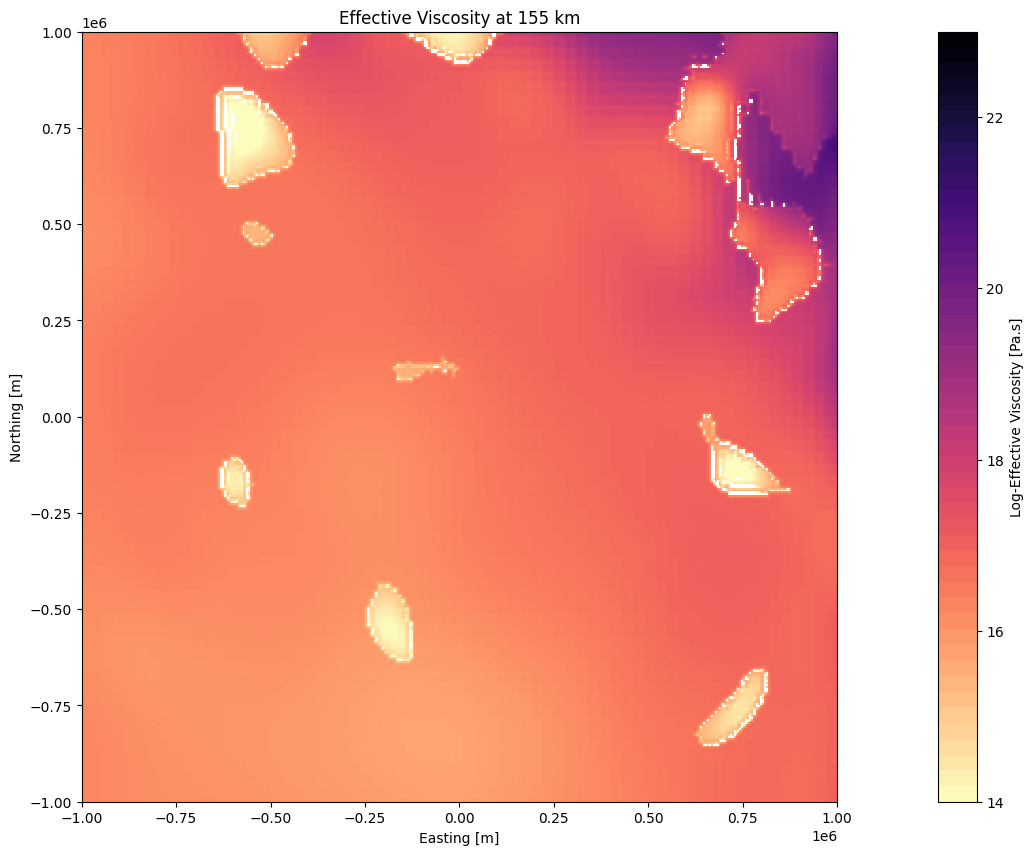

In [11]:
fig = plt.figure(figsize = (13,10))
ax1 = plt.subplot(111)
cax1 = ax1.pcolormesh(xi,yi, np.log10(visc_155), cmap = 'magma_r')
cax1.set_clim(14,23)
cbar_ax = fig.colorbar(cax1, boundaries= np.linspace(14,23), orientation="vertical", pad=0.1,
			 ticks = [14,16,18,20,22], ax = ax1, label = r'Log-Effective Viscosity [Pa.s]')

ax1.clabel(cont, cont.levels, inline = True, fontsize = 8, colors = 'white')
ax1.set_xlim(-1e6,1e6)
ax1.set_ylim(-1e6,1e6)
ax1.set_xlabel('Easting [m]')
ax1.set_ylabel('Northing [m]')
ax1.set_title('Effective Viscosity at 155 km')